In [1]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import KFold

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [4]:
from src.split_dataframe import split_df

In [5]:
df = pd.read_csv('data/aggregated_2014_to_2019.csv')

In [6]:
df = df.sort_values(by=['season','week','game_id']).reset_index(drop=True)

In [7]:
df_train, df_test = split_df(df, 0.3)

In [ ]:
y_train = np.array(df_train.pop('win_game'))
X_train = np.array(df_train.iloc[:,5:])
y_test = np.array(df_test.pop('win_game'))
X_test = np.array(df_test.iloc[:,5:])

# Random Forest Classifier

### 10 fold split

In [ ]:
kfold = KFold(n_splits=10)
accuracies = []
precisions = []
recalls = []
for train_index, test_index in kfold.split(X_train):
    model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
    model.fit(X_train[train_index], y_train[train_index])
    y_predict = model.predict(X_train[test_index])
    y_true = y_train[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

In [ ]:
print("Accuracy:", np.average(accuracies))
print("Precision:", np.average(precisions))
print("Recall:", np.average(recalls))

### Full model

In [ ]:
model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
df_test['win_perc'] = model.predict_proba(X_test)[:,1]
df_test['win_game'] = y_test

In [ ]:
summarized_df = df_test[['game_id','season', 'week','team','opponent','win_perc','win_game']]
summarized_df = summarized_df.sort_values(by='game_id').reset_index(drop=True)
summarized_df.reset_index(drop=True, inplace=True)
summarized_df

In [ ]:
summarized_df['predicted_win'] = None
for i in range(0, len(summarized_df), 2):
    if summarized_df.loc[i, 'win_perc'] > summarized_df.loc[i+1, 'win_perc']:
        summarized_df.loc[i, 'predicted_win'] = 1
        summarized_df.loc[i+1, 'predicted_win'] = 0
    else:
        summarized_df.loc[i, 'predicted_win'] = 0
        summarized_df.loc[i+1, 'predicted_win'] = 1

In [ ]:
summarized_df

In [ ]:
y_true = np.array(summarized_df['win_game'])
y_predict = np.array(summarized_df['predicted_win'])

In [ ]:
print("Accuracy:", accuracy_score(y_true, y_predict))
print("Precision:", precision_score(y_true, y_predict))
print("Recall:", recall_score(y_true, y_predict))

# EDA

In [8]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.describe()

In [ ]:
df.info()

### Split df_train in half to help with visualizing all of the data

In [13]:
df_train_1 = df_train.iloc[:,3:12]
df_train_2 = df_train.iloc[:,12:20]
df_train_3 = df_train.iloc[:,20:30]
df_train_4 = df_train.iloc[:,30:40]
df_train_5 = df_train.iloc[:,40:]

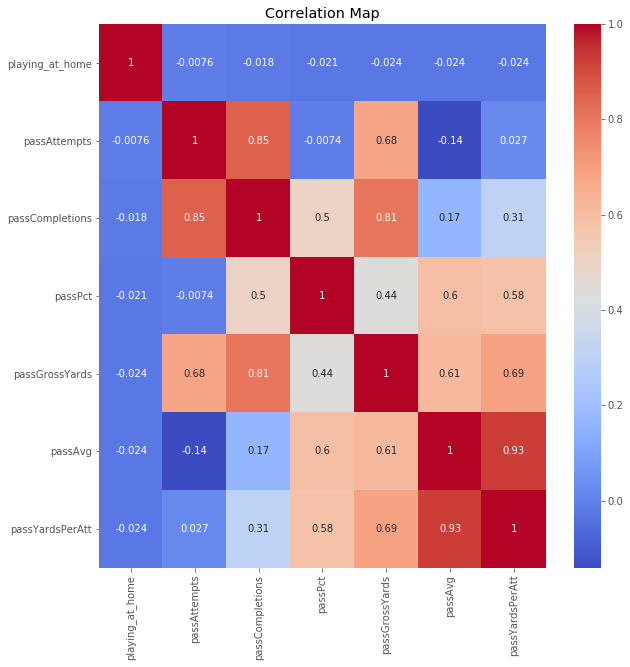

In [15]:
fig,ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_train_1.corr(), annot=True, cmap='coolwarm')
ax.set_title('Correlation Map')
plt.savefig('images/heat_map_1.png')

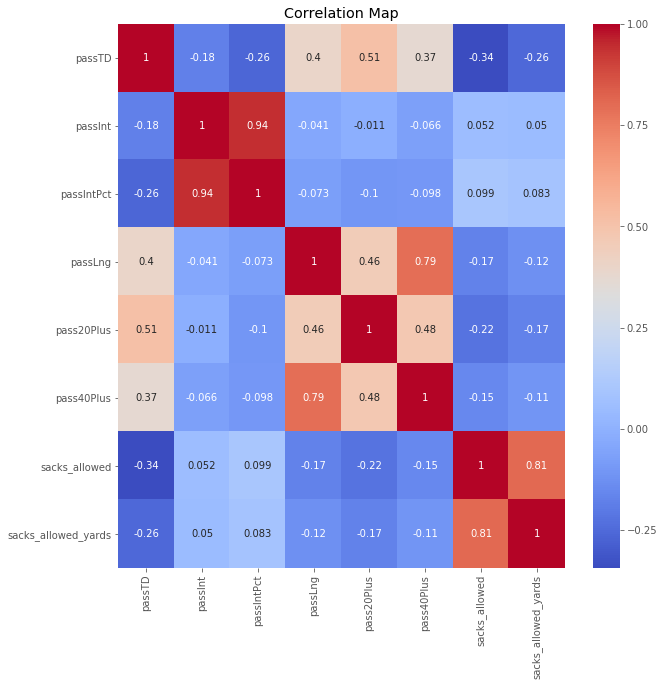

In [16]:
fig,ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_train_2.corr(), annot=True, cmap='coolwarm')
ax.set_title('Correlation Map')
plt.savefig('images/heat_map_2.png')

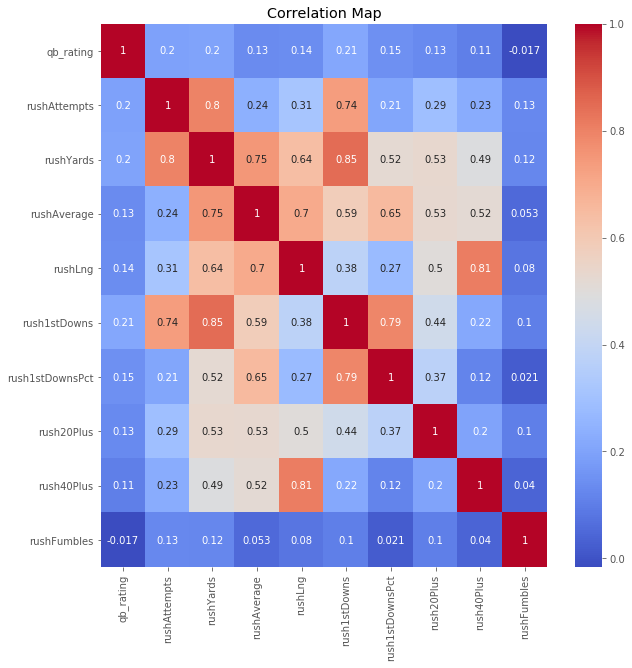

In [17]:
fig,ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_train_3.corr(), annot=True, cmap='coolwarm')
ax.set_title('Correlation Map')
plt.savefig('images/heat_map_3.png')

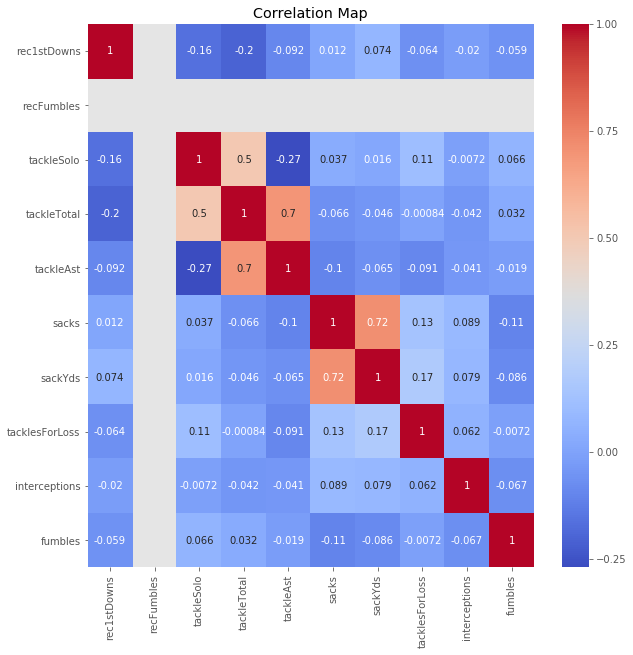

In [19]:
fig,ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_train_4.corr(), annot=True, cmap='coolwarm')
ax.set_title('Correlation Map')
plt.savefig('images/heat_map_4.png')

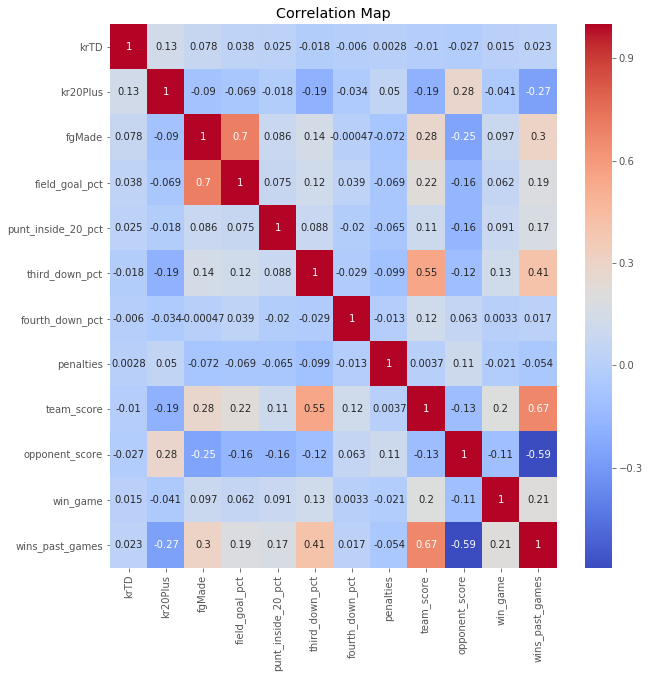

In [20]:
fig,ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_train_5.corr(), annot=True, cmap='coolwarm')
ax.set_title('Correlation Map')
plt.savefig('images/heat_map_5.png')